# Test MFCC

# of test:  11005
# of val:  9981
# of train:  84849
# total:  105835
(10000, 16000)
Loading  10000  files (seconds): 4.3908851146698
Size: 1280000000 bytes
Transforming  10000  elements (seconds): 41.128499031066895
Size: 362880000 bytes


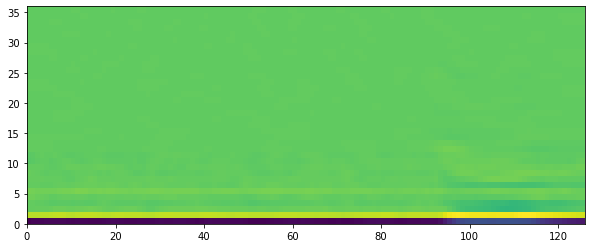

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

import pandas as pd # for reading txt files
import time # for measuring time
import os

sr=16000


basePath = 'sd_GSCmdV2'
testWAVs = pd.read_csv(basePath + '/train/testing_list.txt',
                           sep=" ", header=None)[0].tolist()
testWAVs = [os.path.join(basePath + '/train/', f + '.npy')
                for f in testWAVs if f.endswith('.wav')]

valWAVs = pd.read_csv(basePath + '/train/validation_list.txt',
                          sep=" ", header=None)[0].tolist()
valWAVs = [os.path.join(basePath + '/train/', f + '.npy')
               for f in valWAVs if f.endswith('.wav')]
allWAVs = []
for root, dirs, files in os.walk(basePath + '/train/'):
    allWAVs += [root + '/' + f for f in files if f.endswith('.wav.npy')]
trainWAVs = list(set(allWAVs) - set(valWAVs) - set(testWAVs))

print("# of test: ",len(testWAVs))
print("# of val: ",len(valWAVs))
print("# of train: ",len(trainWAVs))
print("# total: ",len(allWAVs))


#LOAD A BATCH OF DATA
batch_size=10000
dim=sr
start = time.time()
X = np.empty((batch_size, dim))
print(X.shape)
# Generate data
for i, ID in enumerate(allWAVs[0:batch_size]):
    # load data from file, saved as numpy array on disk
    curX = np.load(ID)

    # curX could be bigger or smaller than self.dim
    if curX.shape[0] == dim:
        X[i] = curX
    elif curX.shape[0] > dim:  # bigger
        # we can choose any position in curX-self.dim
        randPos = np.random.randint(curX.shape[0]-dim)
        X[i] = curX[randPos:randPos+dim]
    else:  # smaller
        randPos = np.random.randint(dim-curX.shape[0])
        X[i, randPos:randPos + curX.shape[0]] = curX
        # print('File dim smaller')

end = time.time()
print("Loading ", batch_size, " files (seconds):", end - start)
print("Size: %d bytes" % (X.nbytes))


# FEATURE EXTRACTION OF A BATCH
start = time.time()
features = np.empty((batch_size,36,126))
for i,y in enumerate(X):
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=1024,
                                            hop_length=128, power=1.0, #window='hann',
                                            n_mels=80, fmin=40.0, fmax=sr/2)

    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    log_S = librosa.power_to_db(S, ref=np.max)

    # Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
    mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=12)

    # Let's pad on the first and second deltas while we're at it
    delta_mfcc  = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)

    features[i] = np.concatenate((mfcc, delta_mfcc, delta2_mfcc), axis=0)

end = time.time()
print("Transforming ", batch_size, " elements (seconds):", end - start)
print("Size: %d bytes" % (features.nbytes))
    
    
'''plt.figure(figsize=(10, 4))
plt.pcolormesh(mfcc)
plt.show()

plt.figure(figsize=(10, 4))
plt.pcolormesh(delta_mfcc)
plt.show()

plt.figure(figsize=(10, 4))
plt.pcolormesh(delta2_mfcc)
plt.show()'''

plt.figure(figsize=(10, 4))
plt.pcolormesh(features[0])
plt.show()

In [2]:
del(X)

In [4]:
%reset_selective -f X

In [6]:
%reset_selective -f features